Before you turn this problem in through the moodle, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). Save your notebook with the outputs of the cell visible and then submit on the moodle.

Make sure you fill in any place that says `YOUR CODE HERE`.

# Homewrok 1: MLP from scratch

In this homework, you will code a [Multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron) with one hidden layer to classify cloud of points in 2D.

Advice:
- As much as possible, please try to make matrix and vector operations (good practice for efficient code)
- If you're not familiar with numpy, check the documentation of `np.max`, `np.clip`, `np.random.randn`, `np.reshape`. FYI the matrix multiplication operator is `@`, and you may want to learn about [broadcasting rules](https://numpy.org/doc/stable/user/basics.broadcasting.html) to see how it deals with tensor operations of different sizes
- You can also check about `torch.clamp`, `torch.nn.Parameter`

## 1. Some utilities and your dataset

You should not modify the code in this section

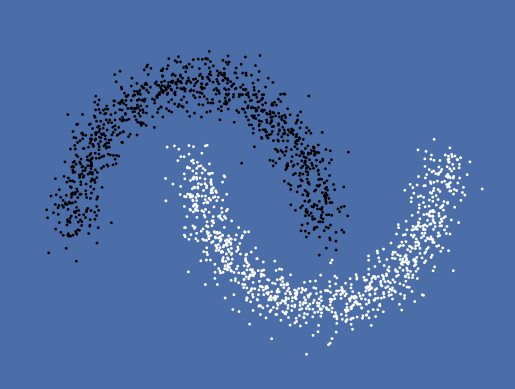

In [1]:
# all of these libraries are used for plotting
import numpy as np
import matplotlib.pyplot as plt

# Plot the dataset
def plot_data(ax, X, Y):
    plt.axis('off')
    ax.scatter(X[:, 0], X[:, 1], s=1, c=Y, cmap='bone')

from sklearn.datasets import make_moons
X, Y = make_moons(n_samples=2000, noise=0.1)

%matplotlib inline
x_min, x_max = -1.5, 2.5
y_min, y_max = -1, 1.5
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plot_data(ax, X, Y)
plt.show()

This is your dataset: two moons each one corresponding to one class (black or white in the picture above).

In order to make it more fun and illustrative, the code below allows you to see the decision boundary of your classifier. Unfortunately, animation is not working on colab...

In [2]:
# Define the grid on which we will evaluate our classifier
xx, yy = np.meshgrid(np.arange(x_min, x_max, .1),
                     np.arange(y_min, y_max, .1))

to_forward = np.array(list(zip(xx.ravel(), yy.ravel())))

# plot the decision boundary of our classifier
def plot_decision_boundary(ax, X, Y, classifier):
    # forward pass on the grid, then convert to numpy for plotting
    Z = classifier.forward(to_forward)
    Z = Z.reshape(xx.shape)
    
    # plot contour lines of the values of our classifier on the grid
    ax.contourf(xx, yy, Z>0.5, cmap='Blues')
    
    # then plot the dataset
    plot_data(ax, X,Y)

## 2. MLP in numpy

Here you need to code your implementation of the [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks) activation and the [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function).

In [3]:
class MyReLU(object):
    def forward(self, x):
        # the relu is y_i = max(0, x_i)
        self.save_for_backward = (x > 0).astype('float')
        return self.save_for_backward * x
        
    
    def backward(self, grad_output):
        # the gradient is 1 for the inputs that were above 0, 0 elsewhere
        self.grad = self.save_for_backward * grad_output
        return self.grad
    
    def step(self, learning_rate):
        # no need to do anything here, since ReLU has no parameters
        pass

class MySigmoid(object):
    def forward(self, x):
        # the sigmoid is y_i = 1./(1+exp(-x_i))
        self.save_for_backward = np.exp(-x)
        return 1. / (1 + self.save_for_backward)
    
    def backward(self, grad_output):
        # the partial derivative is e^-x / (e^-x + 1)^2
        self.grad = (grad_output * self.save_for_backward) / (self.save_for_backward + 1) ** 2
        return self.grad
    
    def step(self, learning_rate):
        # no need to do anything here since Sigmoid has no parameters
        pass

Probably a good time to test your functions...

In [4]:
test_relu = MyReLU()
test_relu.forward(X[10])

array([0.76919449, 0.47145964])

In [5]:
test_relu.backward(np.ones(1))

array([1., 1.])

In [6]:
test_sig = MySigmoid()

test_sig.forward(np.ones(1))

array([0.73105858])

In [7]:
test_sig.backward(np.ones(1))

array([0.19661193])

A bit more complicated, you need now to implement your linear layer i.e. multiplication by a matrix W and summing with a bias b.

In [8]:
class MyLinear(object):
    def __init__(self, n_input, n_output):
        # initialize two random matrices for W and b (use np.random.randn)
        self.W = np.random.randn(n_input, n_output)
        self.b = np.random.randn(1,n_output)

    def forward(self, x):
        # save a copy of x, you'll need it for the backward
        # return xW + b
        self.saved_for_backward = x.copy()
        return x @ self.W + self.b

    def backward(self, grad_output):
        # y_i = \sum_j x_jW_{j,i} + b_i
        # d y_i / d W_{j, i} = x_j
        # d loss / d y_i = grad_output[i]
        # so d loss / d W_{j,i} = x_j * grad_output[i]  (by the chain rule)
        self.grad_W = (grad_output.T @ self.saved_for_backward).T
    
        # d y_i / d b_i = 1
        # d loss / d y_i = grad_output[i]
        self.grad_b = grad_output.copy()
        
        # now we need to compute the gradient with respect to x to continue the back propagation
        # d y_i / d x_j = W_{j, i}
        # to compute the gradient of the loss, we have to sum over all possible y_i in the chain rule
        # d loss / d x_j = \sum_i (d loss / d y_i) (d y_i / d x_j)
        return grad_output @ self.W.T
    
    def step(self, learning_rate):
        # update self.W and self.b in the opposite direction of the stored gradients, for learning_rate
        self.W -= learning_rate * self.grad_W
        self.b -= learning_rate * self.grad_b
        pass

As we did in practicals, you need now to code your network (what we called my_composition in the [practicals](https://github.com/dataflowr/notebooks/blob/master/Module2/02_backprop.ipynb)). Recall with a Sigmoid layer, you should use the BCE loss.

In [9]:
class Sequential(object):
    def __init__(self, layers):
        self.layers = layers
        
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def compute_loss(self, out, label):
        # use the BCE loss
        # -(label * log(output) + (1-label) * log(1-output))
        # save the gradient, and return the loss      
        # beware of dividing by zero in the gradient.
        # split the computation in two cases, one where the label is 0 and another one where the label is 1
        # add a small value (1e-10) to the denominator
        self.loss = - (label * np.log(out) + (1-label) * np.log(1-out))
        if label == 0:
            self.loss_grad =  (1-label) / (1-out + 1e-10)
        else:
            self.loss_grad = - label / (out + 1e-10)
        
        return self.loss

    def backward(self):
        # apply backprop sequentially, starting from the gradient of the loss
        current_grad = self.loss_grad
        for layer in reversed(self.layers):
            current_grad = layer.backward(current_grad)
    
    def step(self, learning_rate):
        # take a gradient step for each layers
        for layer in self.layers:
            layer.step(learning_rate)

In [10]:
h=50

# define your network with your Sequential
# it should be a linear layer with 2 inputs and h outputs, followed by a ReLU
# then a linear layer with h inputs and 1 outputs, followed by a sigmoid
# feel free to try other architectures

net =  Sequential([
    MyLinear(2, h),
    MyReLU(),
    MyLinear(h, 1),
    MySigmoid()
])

<IPython.core.display.Javascript object>


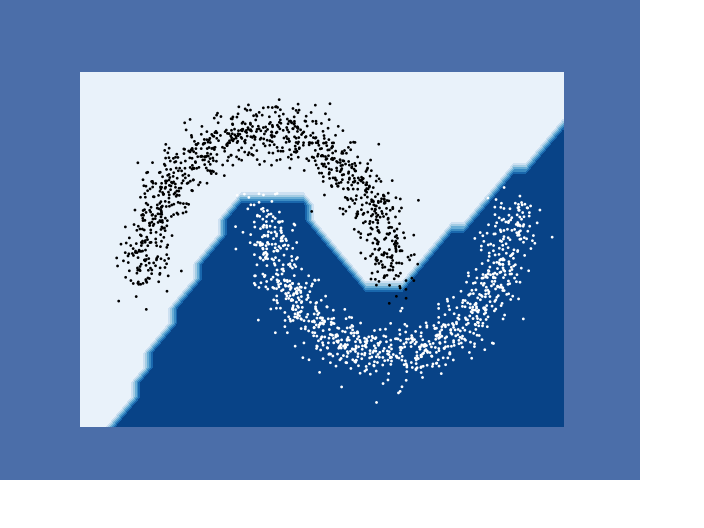

In [11]:
# unfortunately animation is not working on colab
# you should comment the following line if on colab
%matplotlib notebook
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
losses = []
learning_rate = 1e-2
for it in range(10000):
    # pick a random example id
    j = np.random.randint(1, len(X))

    # select the corresponding example and label
    example = X[j:j+1]
    label = Y[j]

    # do a forward pass on the example
    output = net.forward(example)

    # compute the loss according to your output and the label
    loss = net.compute_loss(output, label)
    losses.append(loss.squeeze())
    
    # backward pass
    net.backward()
    
    # gradient step
    net.step(learning_rate)

    # draw the current decision boundary every 250 examples seen
    if it % 250 == 0 : 
        plot_decision_boundary(ax, X,Y, net)
        fig.canvas.draw()
plot_decision_boundary(ax, X,Y, net)
fig.canvas.draw()

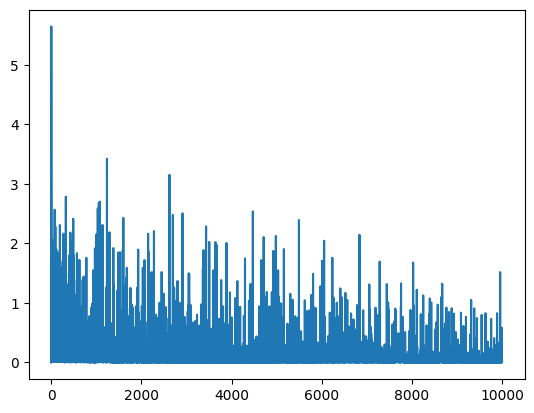

In [12]:
%matplotlib inline
plt.plot(losses)

## 3. Using a Pytorch module

In this last part, use `toch.nn.Module` to recode `MyLinear` and `MyReLU` so that these modules will be pytorch compatible.

In [13]:
import torch
import torch.nn as nn

# y = xW + b
class MyLinear_mod(nn.Module):
    def __init__(self, n_input, n_output):
        super(MyLinear_mod, self).__init__()
        # define self.A and self.b the weights and biases
        # initialize them with a normal distribution
        # use nn.Parameters
        self.A = nn.Parameter(torch.randn(n_input, n_output))
        self.b = nn.Parameter(torch.randn(n_output))

    def forward(self, x):
        return torch.mm(x, self.A) + self.b
        
class MyReLU_mod(nn.Module):
    def __init__(self):
        super(MyReLU_mod, self).__init__()
        
    def forward(self, x):
        return x*(x > 0)

In [14]:
# the grid for plotting the decision boundary should be now made of tensors.
to_forward = torch.from_numpy(np.array(list(zip(xx.ravel(), yy.ravel())))).float()

Define your network using `MyLinear_mod`, `MyReLU_mod` and [`nn.Sigmoid`](https://pytorch.org/docs/stable/nn.html#sigmoid)

In [15]:
h=50

# define your network with nn.Sequential
# use MyLinear_mod, MyReLU_mod and nn.Sigmoid (from pytorch)
net = nn.Sequential(
    MyLinear_mod(2, h),
    MyReLU_mod(),
    MyLinear_mod(h, 1),
    nn.Sigmoid()
)

<IPython.core.display.Javascript object>


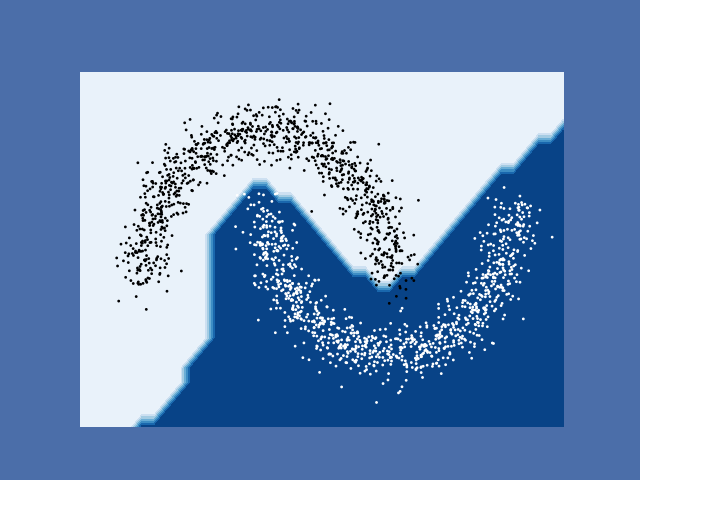

In [16]:
from torch import optim
optimizer = optim.SGD(net.parameters(), lr=1e-2)

X_torch = torch.from_numpy(X).float()
Y_torch = torch.from_numpy(Y).float()

# you should comment the following line if on colab
%matplotlib notebook
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

losses = []
criterion = nn.BCELoss()
for it in range(10000):
    # pick a random example id 
    j = np.random.randint(1, len(X))

    # select the corresponding example and label
    example = X_torch[j:j+1]
    label = Y_torch[j:j+1].unsqueeze(1)

    # do a forward pass on the example
    output = net(example)

    # compute the loss according to your output and the label
    loss = criterion(output, label)
    losses.append(loss.item())

    # zero the gradients
    optimizer.zero_grad()

    # backward pass
    loss.backward()

    # gradient step
    optimizer.step()

    # draw the current decision boundary every 250 examples seen
    if it % 250 == 0 : 
        plot_decision_boundary(ax, X,Y, net)
        fig.canvas.draw()
plot_decision_boundary(ax, X,Y, net)
fig.canvas.draw()

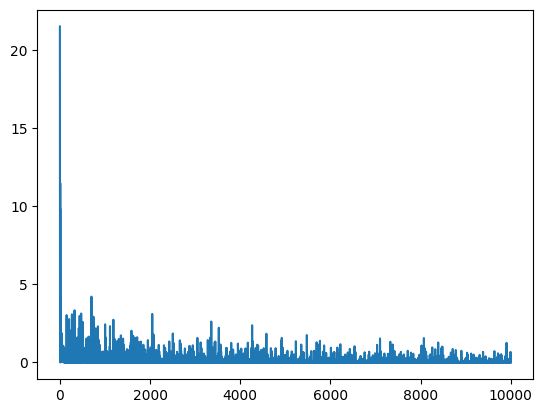

In [17]:
%matplotlib inline
plt.plot(losses)